The data contains 300 rows and 3 columns (from the left, A, B, and C). 
Please build a good regression model which explains column C by a function of  A and B. 

**Note: Please do not use any ML libraries or packages. You can simply attach plot of data points and your regression model that fits the data points and of course, code point (preferably Github).**

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('moloco_regression.csv', names = ['A', 'B', 'C'])

In [3]:
df.head()

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
A    300 non-null float64
B    300 non-null float64
C    300 non-null float64
dtypes: float64(3)
memory usage: 7.1 KB


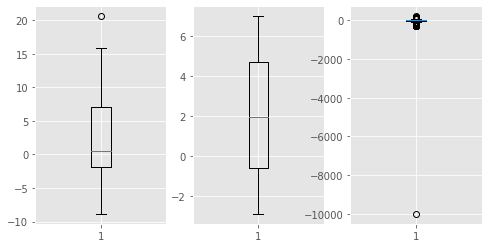

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (8, 4))

ax[0].boxplot(df.A)
ax[1].boxplot(df.B)
ax[2].boxplot(df.C);

There are obviously some outliers from A and C, if we observe the boxplots.   
Let's just drop them!

In [6]:
df.query('A < 20 & C != -10000', inplace=True)

In [7]:
df.describe()

,A,B,C
count,298.000000,298.000000,298.000000
mean,2.229540,2.028303,-7.454616
std,5.596174,2.998541,70.069726
min,-8.860000,-2.890000,-315.000000
25%,-1.960000,-0.593000,-22.775000
50%,0.434000,1.960000,-2.750000
75%,6.987500,4.712500,16.300000
max,15.900000,7.000000,202.000000


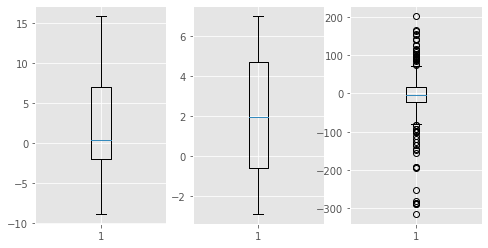

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (8, 4))

ax[0].boxplot(df.A)
ax[1].boxplot(df.B)
ax[2].boxplot(df.C);

In [9]:
# Q1_C, Q3_C = np.percentile(df.C, 25), np.percentile(df.C, 75)
# IQR_C = Q3_C - Q1_C
# lower = Q1_C - 1.5*IQR_C  #Q1 - 1.5 * IQR to find the lower outliers
# higher = Q3_C + 1.5*IQR_C ##Q3 + 1.5 * IQR to find the upper outliers

In [10]:
# df.query('C > @lower & C < @higher', inplace = True)

Much better! Let's get a scatter matrix and inspect the relationship between features and the label.

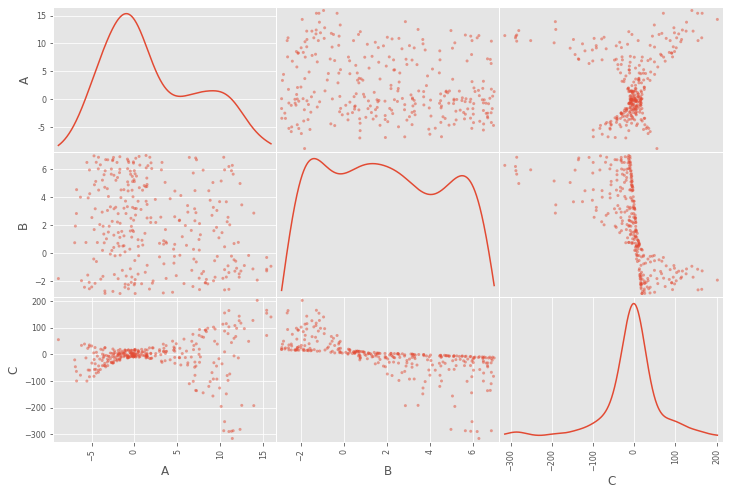

In [11]:
pd.plotting.scatter_matrix(df, figsize=(12, 8), diagonal='kde'); #Plot the scatter matrix and check out the pattern

Hmmm... very interesting! Here let's list some observations:
1. It's not simple linear regression issue; it should be polynominial regression!
2. A and B look independent. 
3. B and C are linear-ish relationship, but A and C are definitely not linear. 

To take a closer inspection, Let's minimize A's effect on B vs. C plot, and check out the plot a bit.   
Let's get a very small chunk of A, and observe the scatter plot of B vs. C.

In [12]:
n = 20  #chunk row size
df_sorted = df.sort_values(['A'])
list_df = [df_sorted[i:i+n] for i in range(0,df_sorted.shape[0],n)]

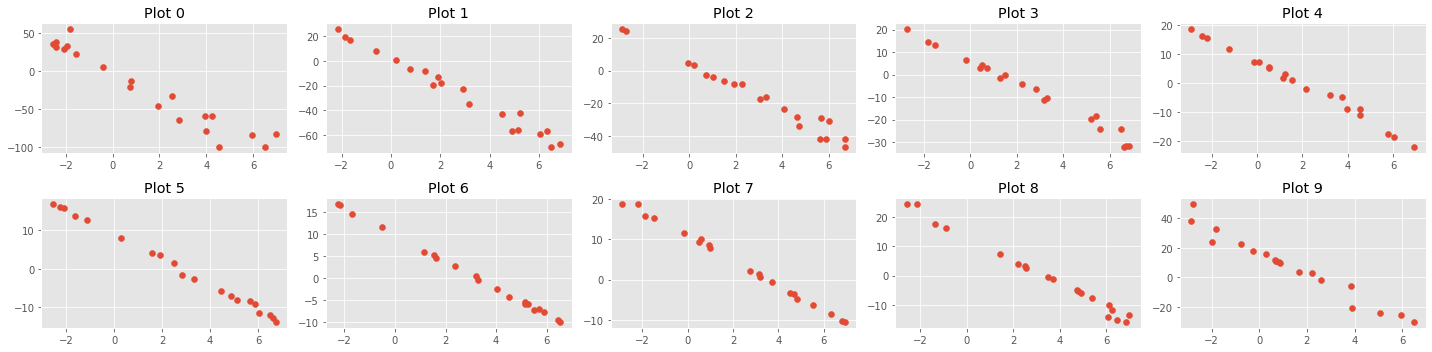

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(20,5))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(list_df[i].B, list_df[i].C)
    ax.set_title('Plot {}'.format(i))
    
plt.tight_layout()

Now it's more clear that B and C are linear.    
Let's do the same thing to B, and see the relationship between A and C. 

In [14]:
n = 20  #chunk row size
df_sorted = df.sort_values(['B'])
list_df = [df_sorted[i:i+n] for i in range(0,df_sorted.shape[0],n)]

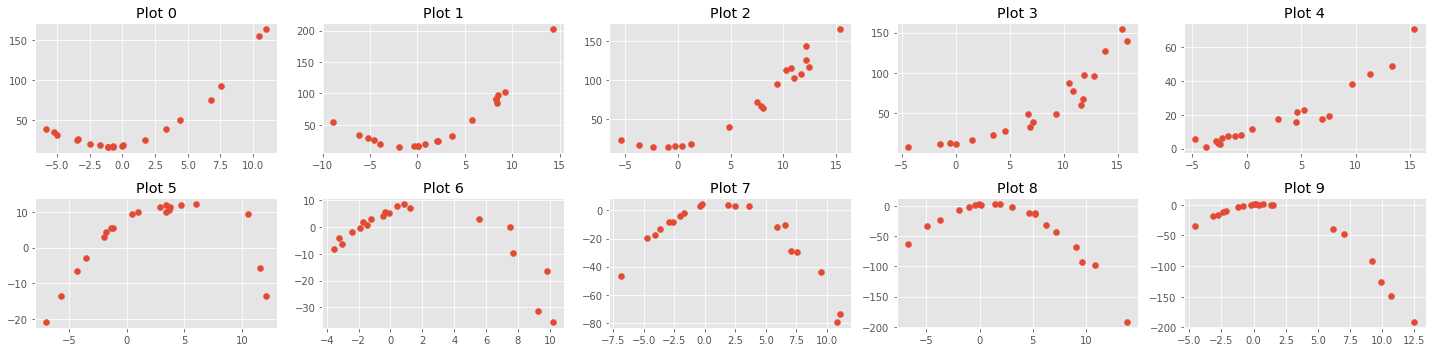

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(20,5))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(list_df[i].A, list_df[i].C)
    ax.set_title('Plot {}'.format(i))
    
plt.tight_layout()

Without the inference from B, the scatter plot is a bell curve. So I guess there's a quadratic relationship between A and C. 

# Model

Since this is not a simple linear regression model, we need to add higher order term into the model to transform the problem into a linear regression problem.   
In this case, we will add $A^2$. We may also need to add some interaction into the model since the scatter matrix tells us $A^2$ and $B$ are interplaying. 

Therefore, the function should be something like:
    $$ C = \beta_0 + \beta_1*A + \beta_2*B + \beta_3*A^2 + \beta_4*A^2*B $$

Now that I'm not allowed to use any ML libraries or packages(WHAT???), let's write a class to find the coefficient and the intercept.

We know that the vector of parameter values $\hat{\beta}$ that minimizes the SSR in the general case is the solution to the matrix equation

 $$ X^T X \hat{\beta} = X^T y $$
 
 Which can also be written as $\hat{\beta} = (X^TX)^{-1}X^Ty$  
 
 Let's just write a class according to this equation

In [16]:
class MyLinearRegression():
    
    def __init__(self, fit_intercept=True):
        """
        Initialize the class!
        fit_intercept: swith between including or excluding 
        the intercept in the model.
        """
        self.coef_ = None
        self.intercept = None
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        """
        Fit model coefficients.
        
        X: 1D or 2D numpy array
        y: 1D numpy array
        """
        
        #check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        
        #if fit_intercept is True, add some bias to X.
        if self.fit_intercept:
            X_biased = np.c_[np.ones(X.shape[0]), X]
        else:
            X_biased = X
            
        xTx = X_biased.T@X_biased
        inverse_xTx = np.linalg.inv(xTx)
        xTy = X_biased.T@y
        coef = inverse_xTx@xTy
        
        # set attribute
        if self.fit_intercept:
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]
            
    def predict(self, X):
        """
        Output model prediction.

        X: 1D or 2D numpy array.
        """
        if len(X.shape) == 1:
            X = X.shape(-1, 1)
        self.predicted_ = self.intercept_ + np.dot(X, self.coef_)
        return self.predicted_

Since we know that we will add $A^2$ and $A^2 * B$, let's add two more columns into the dataset.

In [17]:
df['A_square'] = df.A ** 2
df['AAB'] = df.A * df.A * df.B

In [18]:
df.head()

,A,B,C,A_square,AAB
0,0.490,-0.18,11.50,0.240100,-0.043218
1,-1.410,-1.23,11.80,1.988100,-2.445363
2,0.943,4.51,-3.24,0.889249,4.010513
3,3.570,5.07,-23.90,12.744900,64.616643
4,-1.700,6.91,-22.10,2.890000,19.969900


In [19]:
X = df.drop('C', axis = 1).values
y = df.C.values

In [20]:
lr = MyLinearRegression() #Model

In [21]:
lr.fit(X,y) #fit the model

In [22]:
lr.coef_  #get all the coefficients

array([ 1.99774134e+00, -2.99532384e+00,  3.05579253e-04, -4.00423525e-01])

In [23]:
lr.intercept_ #get the intercept

9.998277453226109

Cool!   

It looks that $\beta_3$ is very small, so let's boldly ignore it.  
Let's round up the numbers and write out the function:

$$ C = 10 + 2 A - 3 B - 0.4 A^2 B $$

# Evaluation

In [24]:
y_hat = lr.predict(X)
residuals =  y - y_hat

Let's plot the fitted values vs. the true values of C

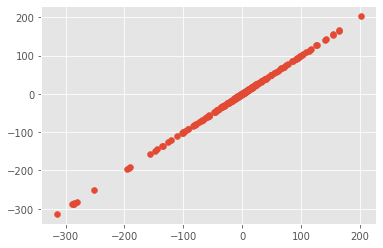

In [25]:
plt.scatter(y, y_hat)

Let's write two functions to get the $R^2$

In [26]:
def R_2(y_hat, y):
    ssr = np.sum((y - y_hat) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    return 1 - ssr/sst

In [27]:
R_2(y_hat, y)

0.9999787346440095

Too good to be true... but I'm confident that it's true. :)

Now Let's plot the original data and the model together to the same coordinate.

In [28]:
from mpl_toolkits.mplot3d import Axes3D

In [32]:
def f(x, y):
    """
    the model function how to get y_hat from A and B.
    """
    return 10 + 2 * x - 3 * y - 0.4 * (x**2) * y 
x = df.A
y = df.B

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

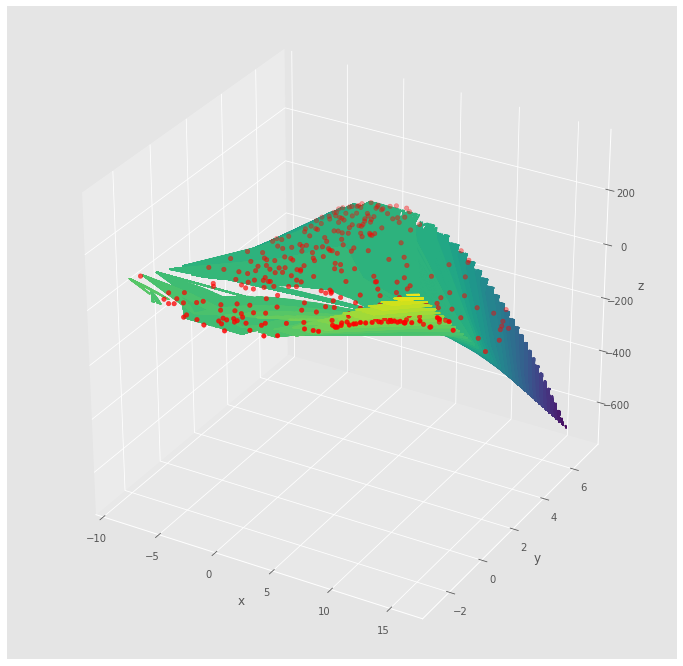

In [33]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(df.A, df.B, df.C, color = 'red')
ax.contour3D(X, Y, Z, 50)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Conclusion

The curved surface shows the function we find out for this interesting dataset.
$$ C = 10 + 2A - 3B - 0.4A^2B $$

# Takeaways

1. We removed two outliers which are quite obvious in the first place, but there could be more. We can try different methods to spot and remove them. In this case, I also tried 1.5IQR to remove more data points and the result is no different. 
2. It's hard to tell any pattern from the scatter matrix, but we can fix one variable and obverse the prediction against the other vaviable. 
3. Usually when we want to add higher order terms, lower order terms should be kept. But in this case, the pattern is two obvious so I didn't add $B^2$, $A^3$, $B^3$, or $A*B^2$. But even if we added them, their coefficients would be extremely small so that we could ignore them. 
4. Significance test of the coefficients is important! I'd love to do it if I'm allowed to use some ML library or packages such as scikit-learn as statsmodels. :)